In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

C:\Users\kshit\AppData\Local\Temp\ipykernel_22756\3790854443.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(beta * (E - mu)))


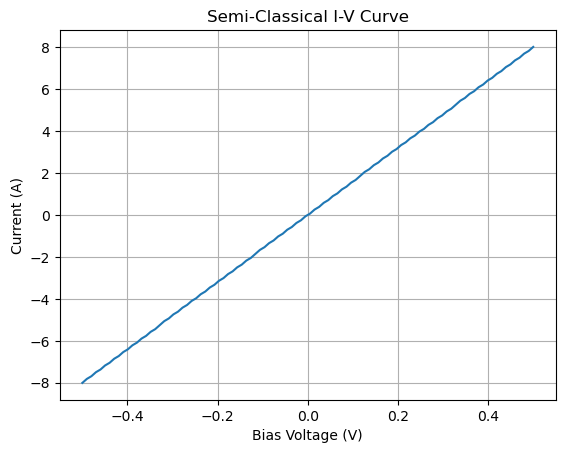

In [2]:

# Constants
q = 1.6e-19      # Charge of electron (Coulombs)
kB = 1.38e-23    # Boltzmann constant (J/K)
T = 300          # Temperature in Kelvin
beta = 1 / (kB * T)
Ef = 0           # Fermi level in eV

# Simulation energy range (eV)
E = np.linspace(-1, 1, 1000)

# Density of states D0 (assumed constant for simplicity)
D0 = 1e21        # states/eV/cm^3 (arbitrary units)

# Contact couplings
nu1 = 0.2        # arbitrary units
nu2 = 0.2        # symmetric for now

# Fermi-Dirac distribution
def fermi(E, mu):
    return 1 / (1 + np.exp(beta * (E - mu)))

# Bias values
bias_vals = np.linspace(-0.5, 0.5, 100)
currents = []

for V in bias_vals:
    mu1 = Ef + V/2
    mu2 = Ef - V/2

    f1 = fermi(E, mu1)
    f2 = fermi(E, mu2)

    # Current per energy
    integrand = (nu1 * nu2 / (nu1 + nu2)) * (f1 - f2)
    I_E = q * D0 * integrand

    # Integrate over energy to get total current
    dE = E[1] - E[0]
    I_total = np.sum(I_E) * dE
    currents.append(I_total)

# Plotting I-V characteristics
plt.plot(bias_vals, currents)
plt.xlabel("Bias Voltage (V)")
plt.ylabel("Current (A)")
plt.title("Semi-Classical I-V Curve")
plt.grid(True)
plt.show()


We will model a 1D lattice with **open boundary conditions** and incorporate **quantum transport using Green’s functions**. The system will consist of:

- A central region (device)
    
- Two contacts (left and right)
    
- Possibly a potential barrier (for tunneling/resonant cases)
    

Let’s lay down the structure first.

### 1. **Hamiltonian of the Device**

For a 1D tight-binding chain:
$$H_{i,j}=\begin{cases}
\epsilon_{i}  & if & i=j\\
-t  & if & \lvert i-j \rvert=1 \\
0 & else
\end{cases}$$
### 2. **Self-Energies of the Contacts $(Σ₁, Σ₂)$**

Use the boundary condition:

$$\psi_{-1}=\psi_{0}e^{ika}-2iB\sin (ka)$$
This leads to the standard form for **retarded self-energy** of semi-infinite leads:

$$\Sigma=te^{ika}$$
and thus:
$$\Gamma=i(\Sigma-\Sigma ^{\dagger})=-2t\sin ka$$
From the dispersion: $$E=\epsilon+2t\cos ka\to ka=\cos^{-1}\left( \frac{E-\epsilon}{2t} \right)$$




### Retarded Greens Function
$$G^R(E)=[(E+i\eta)I-H-\Sigma_1-\Sigma_2]^{-1}$$

### Transmission
$$T(E)=\mathrm{Tr}~{[\Gamma_1G^R\Gamma_2G^A]}$$

### Current Calculation
Using:
$$I_{1}=\frac{q}{h}\int ~dE~~\mathrm{Tr}[\Gamma_{1}G^R\Gamma_{2}G^A]~~(f_{1}-f_{2})$$

### Parameters

In [2]:
# -----------------------
# PARAMETERS
# -----------------------
N = 100                # Number of sites in the device
t = 1.0              # Hopping term
epsilon = 0.0        # On-site energy
a = 1.0              # Lattice constant
eta = 1e-5           # Small imaginary term for numerical stability
kT = 0.025           # Thermal energy ~ 300K
mu1, mu2 = 0.1, -0.1 # Fermi levels for contacts


hysical Meaning:**

- You're modeling a 1D quantum wire with **nearest-neighbor hopping**.
    
- Bias is applied: electrons want to flow from $\mu_1 \to \mu_2$​.
    
- $\eta$ is your **numerical regulator**; it gives the Green’s function the correct **retarded** behavior.
    

---

## 2. 🔧 Hamiltonian

In [3]:
def create_hamiltonian(N, t, epsilon):
    H = np.zeros((N, N), dtype=complex)
    for i in range(N):
        H[i, i] = epsilon
        if i > 0:
            H[i, i - 1] = -t
            H[i - 1, i] = -t
    return H

This builds your **device Hamiltonian**. Each site has:

- **On-site energy** ε\varepsilonε
    
- **Hopping** to neighbor: $−t$
    

This gives you a **tridiagonal tight-binding matrix**, representing a **1D crystal**.

---

## 3. 🧿 Self-Energy and Broadening

In [ ]:
def self_energy(E, t, epsilon):
    arg = (E - epsilon) / (2 * t)
    if np.abs(arg) > 1:
        # Outside propagating region, evanescent modes
        ka = np.arccosh(np.abs(arg)) * 1j * np.sign(arg)
    else:
        ka = np.arccos(arg)
    Sigma = t * np.exp(1j * ka)
    Gamma = 1j * (Sigma - np.conj(Sigma))
    return Sigma, Gamma


Here’s the meat of NEGF: **lead self-energy** $\Sigma$ and **broadening** $\Gamma$:

- $\Sigma = t e^{i k a}$: complex energy shift from semi-infinite lead.
    
- If energy is inside band: **real $k$** → propagating modes.
    
- If outside band: **complex $k$** → evanescent (decaying) modes.
    

### 📌 Physical Picture:

- $\Gamma$ describes **how strongly the lead is coupled** to the device.
    
- It’s also linked to the **density of available states** in the leads.
    

---

## 4. 🟩 Green’s Function

In [ ]:
def green_function(E, H, Sigma1, Sigma2, eta=1e-5):
    H_eff = H.copy()
    H_eff[0, 0] += Sigma1
    H_eff[-1, -1] += Sigma2
    return np.linalg.inv((E + 1j * eta) * np.eye(H.shape[0]) - H_eff)

We're computing the **retarded Green's function**:

$$G^R(E) = \left[ (E + i \eta) I - H - \Sigma_1 - \Sigma_2 \right]^{-1}$$

It tells you:

- How an electron injected at site $i$ propagates to site $j$ with energy $E$.
    
- Self-energies modify just the **first and last site**, where the leads are attached.

## 5. 🚪 Transmission Function

In [ ]:
def transmission(E, H, t, epsilon):
    Sigma1, Gamma1_val = self_energy(E, t, epsilon)
    Sigma2, Gamma2_val = self_energy(E, t, epsilon)

    GR = green_function(E, H, Sigma1, Sigma2)
    GA = GR.conj().T

    Gamma1 = np.zeros_like(H, dtype=complex)
    Gamma2 = np.zeros_like(H, dtype=complex)
    Gamma1[0, 0] = Gamma1_val
    Gamma2[-1, -1] = Gamma2_val

    T = np.real(np.trace(Gamma1 @ GR @ Gamma2 @ GA))
    return T

You're calculating:

$$T(E) = \text{Tr}\left[ \Gamma_1 G^R \Gamma_2 G^A \right]$$

- This is **Caroli formula**: probability that a mode entering from left lead exits into the right.
    
- The $\Gamma$ "open" the system to incoming/outgoing electrons.
    

---

## 6. ⚛️ Fermi Distribution

In [ ]:
def fermi(E, mu, kT):
    return 1.0 / (1.0 + np.exp((E - mu) / kT))

Standard Fermi-Dirac distribution. Tells you:

- Probability that a state at energy $E$ is occupied in a reservoir with chemical potential $\mu$.

---

## 7. ⚡ Current Calculation


In [ ]:
def current(mu1, mu2, H, t, epsilon, kT):
    def integrand(E):
        T_E = transmission(E, H, t, epsilon)
        return T_E * (fermi(E, mu1, kT) - fermi(E, mu2, kT))
    
    I, _ = quad(integrand, -5, 5, limit=1000)
    return I / (2 * np.pi)

This implements the **Landauer-Büttiker formula**:

$$I = \frac{1}{2\pi} \int dE \, T(E) \left[ f_1(E) - f_2(E) \right]$$

- **$f_1 - f_2$​**: population imbalance between contacts
    
- **$T(E)$**: how many electrons actually pass through the channel
    
- Units are arbitrary, unless you multiply by $q$ (charge) and $h$.
    

---

## 8. 📈 Plotting Transmission

In [ ]:
Es = np.linspace(-2.5 * t, 2.5 * t, 500)
Ts = [transmission(E, H, t, epsilon) for E in Es]

plt.plot(Es, Ts)
plt.xlabel("Energy E")
plt.ylabel("Transmission T(E)")
plt.title("Transmission Spectrum")
plt.grid(True)

This shows your **transmission spectrum**:

- Flat region of $T=1$ means **perfect conduction**, i.e., a quantum of conductance.
    
- For 1D wire, you expect $T=1$ within the energy band $[-2t, +2t]$, because only **1 propagating mode** exists.
    
- Outside this range, $T \to 0$: **no available states** in the leads to support transport.
    

---

## 🚀 Key Physical Insights

| Concept             | Intuition                                                              |
| ------------------- | ---------------------------------------------------------------------- |
| Green’s function    | Propagation amplitude through device at energy $E$                     |
| Self-energy         | Effect of coupling the device to infinite leads                        |
| Broadening ($Γ$)    | How many states the lead offers at energy $E$                          |
| Transmission $T(E)$ | Probability that an electron at $E$ tunnels from one lead to the other |
| Current $I$         | Integrated net flow due to Fermi difference between leads              |

Current I = 0.031863 (in arbitrary units)


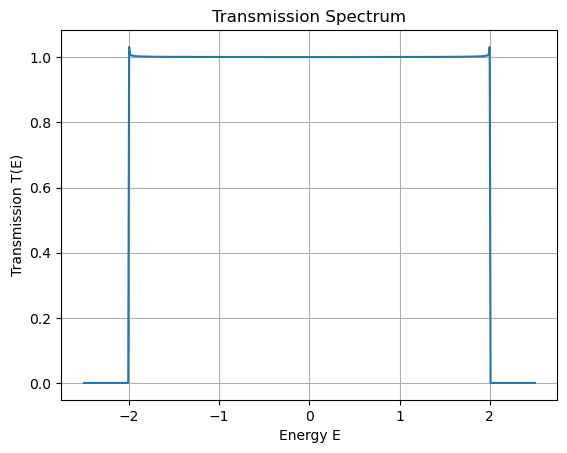

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# -----------------------
# PARAMETERS
# -----------------------
N = 100                # Number of sites in the device
t = 1.0              # Hopping term
epsilon = 0.0        # On-site energy
a = 1.0              # Lattice constant
eta = 1e-5           # Small imaginary term for numerical stability
kT = 0.025           # Thermal energy ~ 300K
mu1, mu2 = 0.1, -0.1 # Fermi levels for contacts

# -----------------------
# DEVICE HAMILTONIAN
# -----------------------
def create_hamiltonian(N, t, epsilon):
    H = np.zeros((N, N), dtype=complex)
    for i in range(N):
        H[i, i] = epsilon
        if i > 0:
            H[i, i - 1] = -t
            H[i - 1, i] = -t
    return H

# -----------------------
# SELF-ENERGY + BROADENING
# -----------------------
def self_energy(E, t, epsilon):
    arg = (E - epsilon) / (2 * t)
    if np.abs(arg) > 1:
        # Outside propagating region, evanescent modes
        ka = np.arccosh(np.abs(arg)) * 1j * np.sign(arg)
    else:
        ka = np.arccos(arg)
    Sigma = t * np.exp(1j * ka)
    Gamma = 1j * (Sigma - np.conj(Sigma))
    return Sigma, Gamma

# -------------------------------------------------
# GREEN'S FUNCTION
# -------------------------------------------------
def green_function(E, H, Sigma1, Sigma2, eta=1e-5):
    H_eff = H.copy()
    H_eff[0, 0] += Sigma1
    H_eff[-1, -1] += Sigma2
    return np.linalg.inv((E + 1j * eta) * np.eye(H.shape[0]) - H_eff)

# -----------------------
# TRANSMISSION FUNCTION
# -----------------------
def transmission(E, H, t, epsilon):
    Sigma1, Gamma1_val = self_energy(E, t, epsilon)
    Sigma2, Gamma2_val = self_energy(E, t, epsilon)

    GR = green_function(E, H, Sigma1, Sigma2)
    GA = GR.conj().T

    Gamma1 = np.zeros_like(H, dtype=complex)
    Gamma2 = np.zeros_like(H, dtype=complex)
    Gamma1[0, 0] = Gamma1_val
    Gamma2[-1, -1] = Gamma2_val

    T = np.real(np.trace(Gamma1 @ GR @ Gamma2 @ GA))
    return T

# -----------------------
# FERMI FUNCTION
# -----------------------
def fermi(E, mu, kT):
    return 1.0 / (1.0 + np.exp((E - mu) / kT))

# -----------------------
# CURRENT CALCULATION
# -----------------------
def current(mu1, mu2, H, t, epsilon, kT):
    def integrand(E):
        T_E = transmission(E, H, t, epsilon)
        return T_E * (fermi(E, mu1, kT) - fermi(E, mu2, kT))
    
    I, _ = quad(integrand, -5, 5, limit=1000)
    return I / (2 * np.pi)

# -----------------------
# MAIN
# -----------------------
H = create_hamiltonian(N, t, epsilon)
I = current(mu1, mu2, H, t, epsilon, kT)
print(f"Current I = {I:.6f} (in arbitrary units)")

# -----------------------
# PLOT T(E)
# -----------------------
Es = np.linspace(-2.5 * t, 2.5 * t, 500)
Ts = [transmission(E, H, t, epsilon) for E in Es]

plt.plot(Es, Ts)
plt.xlabel("Energy E")
plt.ylabel("Transmission T(E)")
plt.title("Transmission Spectrum")
plt.grid(True)
plt.show()
